In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
df = pd.read_csv(
    './data/Estimar_UH2021.txt', engine='python', sep='|',
    parse_dates=[0],
    dayfirst=True,
    decimal=','
)

## Forwardfill product price and drop any missing values from the front

`ffill` in pandas rolls the values forward. This is described as the correct method by the organizer to fill the missing price values.

In [ ]:
from IPython.display import clear_output

df_fill = df.copy()

total = len(df.id.unique())

for i, pid in enumerate(df.id.unique()):
    # This product's entries
    df_prod = df[df.id == pid]
    
    # Fillforward, then back to cover the first few lines
    df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

    # Save to DF
    df_fill.loc[df_prod.index] = df_prod
    
    clear_output(wait=True)
    print("Filled %.1f%% of the Dataframe" % (i/total * 100))

df_fill.to_csv('./data/Estimar_UH2021_filled_precio.txt')

Filled 55.7% of the Dataframe


## Use this DF from here on with the filled Price

In [154]:
df = pd.read_csv(
    './data/Modelar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

C:\Users\garciagr\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [155]:
df.shape

(4045022, 11)

In [156]:
df=df.drop_duplicates()

In [157]:
df.shape

(2038556, 11)

## Feature Engineering and data cleaning

In [158]:
df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')

In [159]:
df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
df['estado_transito'] = (df.estado == 'Transito').astype(int)
df['estado_rotura'] = (df.estado == 'Rotura').astype(int)

df[:5]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura
0,2015-06-01,21972,0,C,75,No Rotura,5.84,0,0,5241.0,0,0,1,0,1,0,0
1,2015-06-01,23910,5,C,1,No Rotura,6.07,0,0,5241.0,3,0,1,0,1,0,0
2,2015-06-01,24306,13,A,46,No Rotura,7.85,0,0,NaN,0,0,1,0,1,0,0
4,2015-06-01,27144,15,E,2,No Rotura,6.12,0,0,4064.0,0,0,1,0,1,0,0
5,2015-06-01,27504,7,C,157,No Rotura,10.74,0,0,5261.0,0,0,1,0,1,0,0


In [160]:
#df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
# df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')

# df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)
#df_fe = pd.concat([df, df_categoria_uno_onehot], axis=1)
df_fe=df
#del df_fe['categoria_uno']
del df_fe['categoria_dos']
del df_fe['estado']
del df_fe['dia_atipico']

df_fe[:5]

,fecha,id,visitas,categoria_uno,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura
0,2015-06-01,21972,0,C,5.84,0,5241.0,0,0,1,0,1,0,0
1,2015-06-01,23910,5,C,6.07,0,5241.0,3,0,1,0,1,0,0
2,2015-06-01,24306,13,A,7.85,0,NaN,0,0,1,0,1,0,0
4,2015-06-01,27144,15,E,6.12,0,4064.0,0,0,1,0,1,0,0
5,2015-06-01,27504,7,C,10.74,0,5261.0,0,0,1,0,1,0,0


### Onehot encoding of Months

In [ ]:
df_weekday_onehot = pd.get_dummies(df_fe.fecha.dt.weekday, prefix='fecha_weekday_')
df_month_onehot = pd.get_dummies(df_fe.fecha.dt.month, prefix='fecha_month_')

df_fe = pd.concat([df_fe, df_weekday_onehot, df_month_onehot], axis=1)
del df_fe['fecha']

df_fe

## Sin-Cos transform of Month / Weekday

In [161]:
df_fe['weekday_sin'] = np.sin(df.fecha.dt.weekday * (2*np.pi/7))
df_fe['weekday_cos'] = np.cos(df.fecha.dt.weekday * (2*np.pi/7))

# df_fe['month_sin'] = np.sin((df.fecha.dt.month-1) * (2*np.pi/12))
# df_fe['month_cos'] = np.cos((df.fecha.dt.month-1) * (2*np.pi/12))

month_con=df_fe["fecha"].dt.month + (df_fe["fecha"].dt.day / df_fe["fecha"].dt.days_in_month)
df_fe['month_sin'] = np.sin((month_con-1) * (2*np.pi/12))
df_fe['month_cos'] = np.cos((month_con-1) * (2*np.pi/12))


# del df_fe['fecha']

df_fe

,fecha,id,visitas,categoria_uno,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura,weekday_sin,weekday_cos,month_sin,month_cos
0,2015-06-01,21972,0,C,5.84,0,5241.0,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01
1,2015-06-01,23910,5,C,6.07,0,5241.0,3,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01
2,2015-06-01,24306,13,A,7.85,0,NaN,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01
4,2015-06-01,27144,15,E,6.12,0,4064.0,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01
5,2015-06-01,27504,7,C,10.74,0,5261.0,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045016,2016-09-30,456982,6575,F,81.28,0,NaN,30,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16
4045017,2016-09-30,457416,1395,F,50.38,0,130.0,9,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16
4045018,2016-09-30,457422,1080,F,93.77,0,130.0,0,0,1,0,0,0,1,-0.433884,-0.900969,-1.00000,-1.836970e-16
4045019,2016-09-30,458650,1385,K,70.85,0,126.0,0,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16


## Data Quality (NANs etc)

### TODO: Better `antiguedad` fill

In [133]:
df_fe_no_nans = df_fe.dropna(how='any', inplace=False)
df_fe_no_nans[:5]

,fecha,id,visitas,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,...,categoria_uno__H,categoria_uno__I,categoria_uno__K,categoria_uno__L,categoria_uno__N,categoria_uno__O,weekday_sin,weekday_cos,month_sin,month_cos
0,2015-06-01,21972,0,5.84,0,5241.0,0,0,1,0,...,0,0,0,0,0,0,0.0,1.0,0.48481,-0.87462
1,2015-06-01,23910,5,6.07,0,5241.0,3,0,1,0,...,0,0,0,0,0,0,0.0,1.0,0.48481,-0.87462
4,2015-06-01,27144,15,6.12,0,4064.0,0,0,1,0,...,0,0,0,0,0,0,0.0,1.0,0.48481,-0.87462
5,2015-06-01,27504,7,10.74,0,5261.0,0,0,1,0,...,0,0,0,0,0,0,0.0,1.0,0.48481,-0.87462
6,2015-06-01,30014,5,6.12,0,2954.0,3,0,1,0,...,0,0,0,0,0,0,0.0,1.0,0.48481,-0.87462


Remove antiguedad perquè és una basura!

In [134]:
df_fe_no_nans=df_fe_no_nans.drop(["antiguedad"],axis=1)

## Visualize time series for Sold units (Target)

Grouped by date.

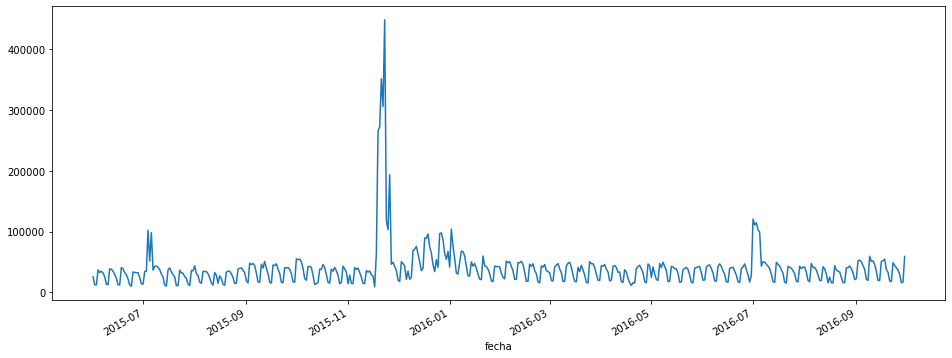

In [38]:
plt.figure(figsize=[16,6])

data = df_fe.groupby('fecha').sum().sort_values('fecha')
data.unidades_vendidas.plot()

## Distribution of the Target Variable

- Unbalanced data set (so many lines are of value 0)
- Long tail of numbers, follows zipf distribution more or less, where nth number is proportional to 1/n

In [ ]:
plt.figure(figsize=[16,6])

data = df_fe.unidades_vendidas[df_fe.unidades_vendidas < 50]

sns.histplot(data // 3, bins=50)

## Single product target variable Plot

In [ ]:
plt.figure(figsize=[16,6])

data = df_fe[['fecha', 'id', 'unidades_vendidas']]
data = data.groupby(['fecha','id']).sum()

pid = 21972
data.loc[(slice(None), slice(pid)), :].unidades_vendidas.plot()

In [ ]:
[c for c in df_fe.columns]

In [ ]:
sns.pairplot(df[::1000])

## Naive DS : Random forest

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data = df_fe_no_nans[::100]

X = data[df_fe.columns.values[2:]]
del X['unidades_vendidas']

y = data['unidades_vendidas']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [ ]:
X_train

## Rescale `precio` / `antiguedad`

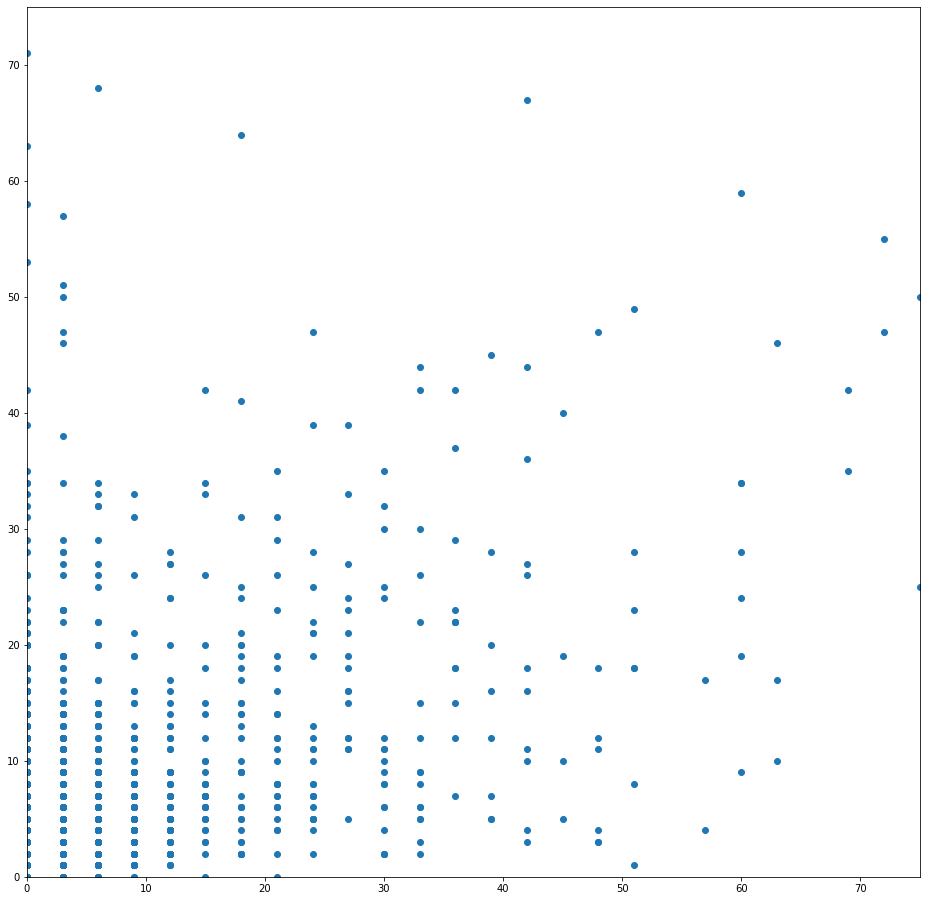

In [69]:
plt.figure(figsize=[16,16])
plt.xlim([0,75])
plt.ylim([0,75])
plt.scatter(x=y_test, y=y_hat)

## Autogluon

In [12]:
import autogluon.core as ag
from autogluon import TabularPrediction as task

In [162]:
df=df_fe
df=df.drop(["fecha","id","antiguedad"],axis=1)

In [163]:
import random
np.random.seed(20)
msk = np.random.rand(len(df)) < 0.9

train = df[msk]

test = df[~msk]

In [164]:
train_data = task.Dataset(train)
test_data = task.Dataset(test)
subsample_size = 1000000  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=20)
train_data

,visitas,categoria_uno,precio,campaña,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura,weekday_sin,weekday_cos,month_sin,month_cos
26395,10,G,21.17,0,6,0,1,0,1,0,0,0.433884,-0.900969,0.438371,-0.898794
4029757,55,A,37.70,0,0,0,1,0,1,0,0,0.433884,-0.900969,-0.999848,-0.017452
1030587,54,A,37.41,0,0,0,1,0,1,0,0,-0.974928,-0.222521,-0.998717,0.050649
3674701,120,A,31.72,0,3,0,1,0,1,0,0,0.974928,-0.222521,-0.724793,-0.688967
2105415,0,H,54.25,0,0,0,1,0,1,0,0,0.781831,0.623490,0.633521,0.773726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449084,90,A,11.86,0,0,0,1,0,1,0,0,0.433884,-0.900969,-0.347305,-0.937752
362221,56,K,81.63,0,0,0,1,0,0,0,1,0.781831,0.623490,-0.234266,-0.972172
388062,18,A,32.94,0,0,0,1,0,0,0,1,-0.433884,-0.900969,-0.283206,-0.959059
906108,25,C,6.12,0,12,0,1,0,1,0,0,-0.433884,-0.900969,-0.978148,-0.207912


In [166]:
directory=r"D:\test"
time_limits = 3600 # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
presets="medium_quality_faster_train" # roduces less accurate models but facilitates faster prototyping
predictor = task.fit(train_data=train_data,
                     output_directory=directory,
                     label="unidades_vendidas", 
                     time_limits=time_limits,
                     presets=presets,
                     eval_metric="root_mean_squared_error",
                    problem_type="regression")

Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to D:\test\
AutoGluon Version:  0.0.14
Train Data Rows:    1000000
Train Data Columns: 14
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24516.81 MB
	Train Data (Original)  Memory Usage: 146.0 MB (0.6% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 5 | ['precio', 'weekday_sin', 'weekday_cos',

In [167]:
predictor.leaderboard(test_data,silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestRegressorMSE,-10.914847,-12.471817,6.782829,0.237998,211.846033,6.782829,0.237998,211.846033,0,True,1
1,weighted_ensemble_k0_l1,-11.338878,-11.364404,25.749454,1.140599,2074.099889,0.347044,0.000000,0.711576,1,True,10
2,LightGBMRegressorCustom,-11.440851,-12.680820,0.379144,0.034038,4.205760,0.379144,0.034038,4.205760,0,True,9
3,LightGBMRegressor,-11.783164,-12.054869,0.159997,0.024060,3.541277,0.159997,0.024060,3.541277,0,True,5
4,CatboostRegressor,-11.959262,-11.988569,0.063696,0.022003,30.733324,0.063696,0.022003,30.733324,0,True,7
5,ExtraTreesRegressorMSE,-12.132205,-12.383112,6.273131,0.120000,120.367204,6.273131,0.120000,120.367204,0,True,2
6,NeuralNetRegressor,-12.320153,-12.270896,9.883268,0.531077,1640.068605,9.883268,0.531077,1640.068605,0,True,8
7,LightGBMRegressorXT,-13.016653,-13.020732,0.152003,0.020001,2.888589,0.152003,0.020001,2.888589,0,True,6
8,KNeighborsRegressorDist,-14.875369,-15.994317,2.699934,0.222116,67.587286,2.699934,0.222116,67.587286,0,True,4
9,KNeighborsRegressorUnif,-15.589846,-19.477230,2.399485,0.229521,70.373147,2.399485,0.229521,70.373147,0,True,3


In [188]:
def myround(x, base=3):
    return base * np.round_(x/base)

In [189]:
yhat=predictor.predict(test_data)
yhat_rounded=myround(yhat)

In [191]:
from sklearn.metrics import mean_squared_error as mse

print(mse(test_data.unidades_vendidas, yhat))
print(mse(test_data.unidades_vendidas, yhat_rounded))

128.59638704544116
129.17048776886352


In [170]:
test_f = df_fe[~msk]
test_f["prediction"]=yhat

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
test_f

,fecha,id,visitas,categoria_uno,precio,campaña,antiguedad,unidades_vendidas,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_no_rotura,estado_transito,estado_rotura,weekday_sin,weekday_cos,month_sin,month_cos,prediction
27,2015-06-01,56310,11,C,10.17,0,4355.0,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,4.624325
93,2015-06-01,80454,29,A,24.21,0,NaN,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,1.194967
116,2015-06-01,85388,33,G,17.20,0,3246.0,0,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,3.281117
145,2015-06-01,86924,6,C,8.79,0,3195.0,9,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,2.651236
188,2015-06-01,92324,9,C,10.76,0,3011.0,3,0,1,0,1,0,0,0.000000,1.000000,0.48481,-8.746197e-01,2.049594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044987,2016-09-30,443662,1080,K,47.12,0,166.0,33,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,28.121780
4044992,2016-09-30,445634,17730,F,57.55,0,160.0,153,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,169.465973
4044995,2016-09-30,446500,1230,K,64.29,0,159.0,18,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,21.419184
4045014,2016-09-30,454656,120,K,10.17,0,134.0,42,0,1,0,1,0,0,-0.433884,-0.900969,-1.00000,-1.836970e-16,20.438971


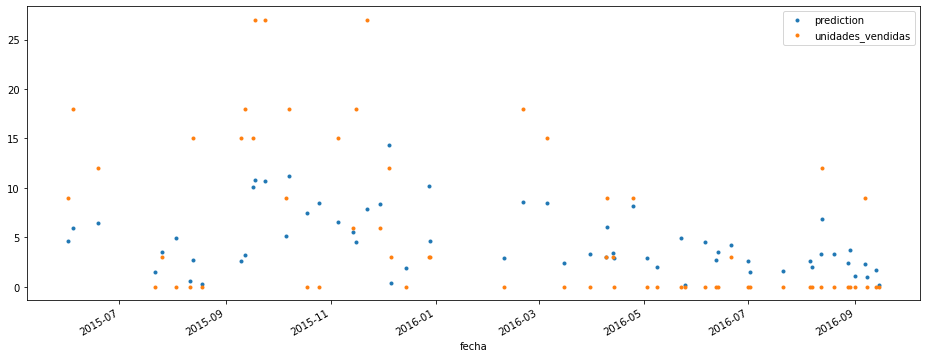

In [194]:
plt.figure(figsize=[16,6])

data = test_f[test_f["id"]==56310].groupby('fecha').mean().sort_values('fecha')
data["prediction"].plot(label="prediction",style=".")

data = test_f[test_f["id"]==56310].groupby('fecha').mean().sort_values('fecha')
data.unidades_vendidas.plot(style=".")
plt.legend()

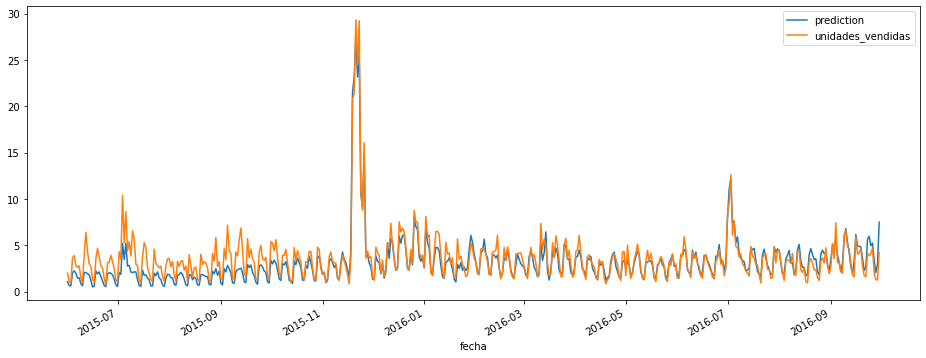

In [196]:
plt.figure(figsize=[16,6])

data = test_f.groupby('fecha').mean().sort_values('fecha')
data["prediction"].plot(label="prediction")

data = test_f.groupby('fecha').mean().sort_values('fecha')
data.unidades_vendidas.plot()
plt.legend()

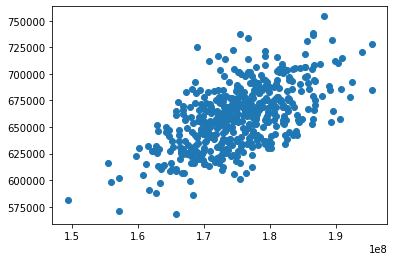

In [123]:
plt.scatter(data["id"],data["antiguedad"])

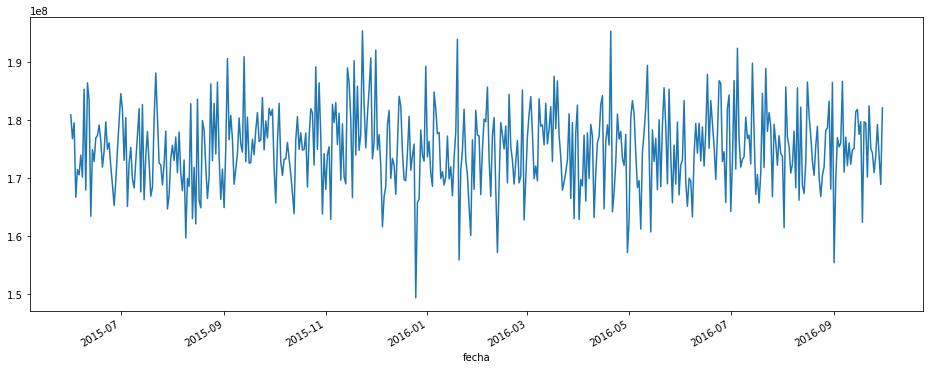

In [120]:
plt.figure(figsize=[16,6])

data = test_f.groupby('fecha').sum().sort_values('fecha')
data.id.plot(label="prediction")

